# Compact architectures
## Audio Classification with the ESC-50 dataset

This notebook performs audio classification on audio fragments of 5 seconds long

In [1]:
# IMPORT ALL LIBRARIES

import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import random
import seaborn as sns

import librosa
import librosa.display

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tensorflow.keras.layers import Layer, Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Load the data

### ESC-50 dataset

In [2]:
# Set sample rate to work with at 8000

SR = 16000

In [3]:
info = pd.read_csv('/kaggle/input/esc50dataset/ESC-50-master/ESC-50-master/meta/esc50.csv')

In [4]:
info_list = list(info['category'].unique())

labels = {}

for i, label in enumerate(info_list):
        labels[label] = i

NUM_CLASSES = len(labels)

In [5]:
# Create a new empty dictionary
reversed_labels = {}

# Iterate through the key-value pairs in the dictionary
for key, value in labels.items():
  # Add the key-value pair to the new dictionary in the reverse order
  reversed_labels[value] = key

In [6]:
esc50_files = list(info['filename'])

### Load the wav files

In [7]:
ESC50_FOLDER = '/kaggle/input/esc50dataset/ESC-50-master/ESC-50-master/audio'

In [8]:
def wav_data_loader(files, normalization=True):
    
    all_fragments = []
    
    for file in files:
        
        # Load the audio file
        
        AUDIO_FILE = os.path.join(ESC50_FOLDER, file)
        
        sample, sample_rate = librosa.load(AUDIO_FILE, sr=SR)
        
        if normalization==True:
            
            # Normalize the waveform
            sample = librosa.util.normalize(sample)
        
        cat = info[info['filename'] == file]['category'].iloc[0]
        
        sample = (sample, labels[cat])    
    
        all_fragments.append(sample)
    
    return all_fragments

In [9]:
%%time
esc50_wav_dataset = wav_data_loader(esc50_files, normalization=False)

CPU times: user 16.6 s, sys: 1.48 s, total: 18.1 s
Wall time: 59.4 s


In [10]:
len(esc50_wav_dataset)

2000

## Train-test split

Creating a first train-test split in the original dataset will be useful for correct data augmentation and pre-processing techniques.

In [11]:
X = [wav[0] for wav in esc50_wav_dataset]
y = [wav[1] for wav in esc50_wav_dataset]

X_train_wav, X_test_wav, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_train_wav, X_val_wav, y_train, y_val = train_test_split(X_train_wav, y_train, test_size=0.2, stratify=y_train, random_state=42)

## Waveform augmentation

In [12]:
## Noise addition

def add_noise(wav_data, noise_factor):

    # Generate noise signal with the same shape as input waveform
    noise = np.random.normal(0, 1, len(wav_data))

    # Scale noise signal with the permissible noise factor value
    noise *= noise_factor

    # Add noise signal to input waveform
    augmented_wav_data = wav_data + noise

    # Normalize the augmented waveform data
    augmented_wav_data = librosa.util.normalize(augmented_wav_data)

    return augmented_wav_data

def time_shift(audio, p):
    """
    Shift audio to the left or right by a random amount.
    """
    # Calculate the length of the audio array
    length = audio.shape[0]

    # Calculate the maximum number of samples to shift
    max_shift = int(length * p)

    # Generate a random shift value
    shift = random.randint(-max_shift, max_shift)

    # Create an empty array with the same shape as the audio array
    shifted_audio = np.zeros_like(audio)

    # Shift the audio by the specified number of samples
    if shift > 0:
      # Shift to the right
        shifted_audio[shift:] = audio[:length-shift]
    else:
        # Shift to the left
        shifted_audio[:length+shift] = audio[-shift:]
    
    if np.sum(shifted_audio) == 0:
        #revert the process if all information was erased
        shifted_audio = audio     

    return shifted_audio

def time_stretching(audio,factor):
    
    wav_time_stch = librosa.effects.time_stretch(audio,rate=factor)
    
    return wav_time_stch[:SR*5]

In [13]:
len(X_train_wav)

1120

In [14]:
%%time
''' EXUCUTE THIS CELL TO APPLY DATA AUGMENTATION
Lots of memory required this step could be optimized'''

def augment_wavs(wav_dataset, y):
    
    wav_dataset_augmented = []

    for wav in wav_dataset:
        # Create a copy of the original wav to prevent unwanted side effects
        temp_wav = wav.copy()
        temp_wav = add_noise(temp_wav, 0.025) # We want to use values between 0.005 and 0.04
        temp_wav = time_shift(temp_wav, 0.3)  # We want to use a max shift of 30%
        temp_wav = time_stretching(temp_wav, 0.85)

        wav_dataset_augmented.append(temp_wav)

    # Add original wavs to augmented list
    wav_dataset_augmented.extend(wav_dataset)
    
    y = y + y #each spec is being appended at the bottom of the list

    return wav_dataset_augmented, y

X_train_wav, y_train = augment_wavs(X_train_wav, y_train)

CPU times: user 1min 10s, sys: 583 ms, total: 1min 10s
Wall time: 1min 11s


In [15]:
len(X_train_wav)

2240

# Training

## Basic CNN architecture

In [55]:
class LLF(Layer):
    def __init__(self, sample_rate, frame_length, frame_step, num_mel_bins=64, lower_freq=125, upper_freq=7500, log_offset=0.001, **kwargs):
        super(LLF, self).__init__(**kwargs)
        self.sample_rate = sample_rate
        self.frame_length = frame_length
        self.frame_step = frame_step
        self.num_mel_bins = num_mel_bins
        self.lower_freq = lower_freq
        self.upper_freq = upper_freq
        self.log_offset = log_offset

    def call(self, inputs):
        
        # Convert numpy array to Tensor and normalize based on its actual max and min values
        wav = tf.cast(inputs, tf.float32)
        audio_tensor = (wav - tf.math.reduce_min(wav)) / (tf.math.reduce_max(wav) - tf.math.reduce_min(wav)) * 2 - 1
        
        # Compute the Short-Time Fourier Transform (STFT)
        stft = tf.signal.stft(wav, self.frame_length, self.frame_step, window_fn=tf.signal.hann_window)

        # Compute the spectrogram
        spectrogram = tf.abs(stft)

        # Compute the mel-spectrogram
        num_spectrogram_bins = stft.shape[-1]
        linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
            self.num_mel_bins, num_spectrogram_bins, self.sample_rate, self.lower_freq, self.upper_freq)
        mel_spectrogram = tf.tensordot(spectrogram, linear_to_mel_weight_matrix, 1)
        mel_spectrogram.set_shape(spectrogram.shape[:-1].concatenate(linear_to_mel_weight_matrix.shape[-1:]))

        # Compute the log mel-spectrogram
        log_mel_spectrogram = tf.math.log(mel_spectrogram + self.log_offset)

        # Add a channel dimension
        log_mel_spectrogram = tf.expand_dims(log_mel_spectrogram, -1)

        return log_mel_spectrogram

sample_rate = SR  # Adjust as necessary
window_size_ms = 25
window_hop_ms = 10
frame_length = sample_rate * window_size_ms // 1000
frame_step = sample_rate * window_hop_ms // 1000
AUDIO_LENGTH = 5

class HLFBlock(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(HLFBlock, self).__init__(**kwargs)
        self.seq = Sequential([
            tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        ])

    def call(self, inputs):
        return self.seq(inputs)

class EmbeddingsBlock(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(EmbeddingsBlock, self).__init__(**kwargs)
        self.seq = Sequential([
            tf.keras.layers.Conv2D(256, 1, padding='same', activation='relu'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.GlobalAveragePooling2D(),
        ])

    def call(self, inputs):
        return self.seq(inputs)
    
HLF = HLFBlock(name='HLF')
Embeddings = EmbeddingsBlock(name='Embeddings')

# Define the model
model = Sequential([
    LLF(sample_rate, frame_length, frame_step, input_shape=(AUDIO_LENGTH*SR,)),
    HLF,
    Embeddings,
    tf.keras.layers.Dense(NUM_CLASSES),
    tf.keras.layers.Activation('softmax')  # The activation should be softmax for multi-class classification
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(np.array(X_train_wav), np.array(y_train), epochs=50, batch_size=32, validation_data=(np.array(X_val_wav), np.array(y_val)))

Epoch 1/50


2023-06-11 10:07:15.692758: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_18/Embeddings/sequential_17/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


70/70 [==============================] - 5s 34ms/step - loss: 3.5487 - accuracy: 0.0996 - val_loss: 3.6668 - val_accuracy: 0.0500
Epoch 2/50
70/70 [==============================] - 2s 25ms/step - loss: 2.8941 - accuracy: 0.2067 - val_loss: 3.6919 - val_accuracy: 0.0607
Epoch 3/50
70/70 [==============================] - 2s 23ms/step - loss: 2.5484 - accuracy: 0.2821 - val_loss: 3.6707 - val_accuracy: 0.1107
Epoch 4/50
70/70 [==============================] - 2s 23ms/step - loss: 2.2604 - accuracy: 0.3634 - val_loss: 3.2825 - val_accuracy: 0.2071
Epoch 5/50
70/70 [==============================] - 2s 23ms/step - loss: 2.0746 - accuracy: 0.4062 - val_loss: 2.6259 - val_accuracy: 0.3000
Epoch 6/50
70/70 [==============================] - 2s 23ms/step - loss: 1.8958 - accuracy: 0.4518 - val_loss: 2.6066 - val_accuracy: 0.3357
Epoch 7/50
70/70 [==============================] - 2s 23ms/step - loss: 1.7197 - accuracy: 0.5143 - val_loss: 1.8493 - val_accuracy: 0.4607
Epoch 8/50
70/70 [======

In [56]:
# Performance Evaluation
test_loss, test_accuracy = model.evaluate(np.array(X_test_wav), np.array(y_test), verbose=2)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

19/19 - 0s - loss: 1.6241 - accuracy: 0.6700 - 221ms/epoch - 12ms/step
Test loss: 1.6240730285644531
Test accuracy: 0.6700000166893005


In [57]:
# Computational complexity evaluation
total_params = model.count_params()
print(f'Total parameters: {total_params}')

Total parameters: 139442


In [58]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 llf_5 (LLF)                 (None, 498, 64, 1)        0         
                                                                 
 HLF (HLFBlock)              (None, 31, 4, 128)        93568     
                                                                 
 Embeddings (EmbeddingsBlock  (None, 256)              33024     
 )                                                               
                                                                 
 dense_6 (Dense)             (None, 50)                12850     
                                                                 
 activation_6 (Activation)   (None, 50)                0         
                                                                 
Total params: 139,442
Trainable params: 138,994
Non-trainable params: 448
_____________________________________________

### Visualization of the training process

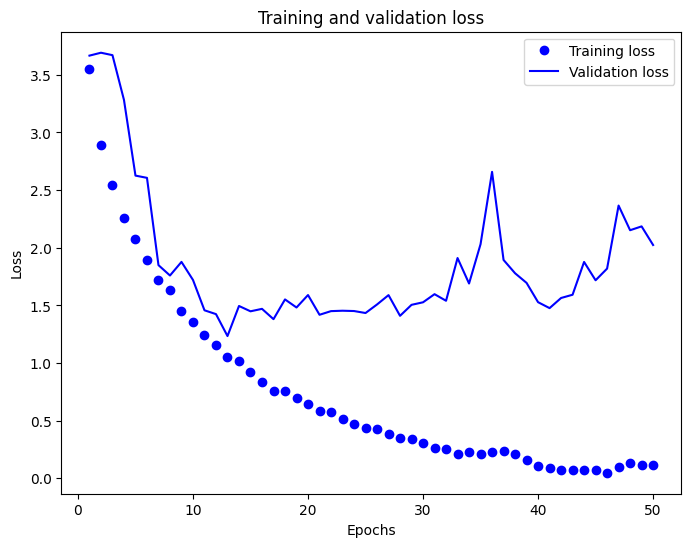

In [59]:
# Plot the loss curves for training and validation.

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

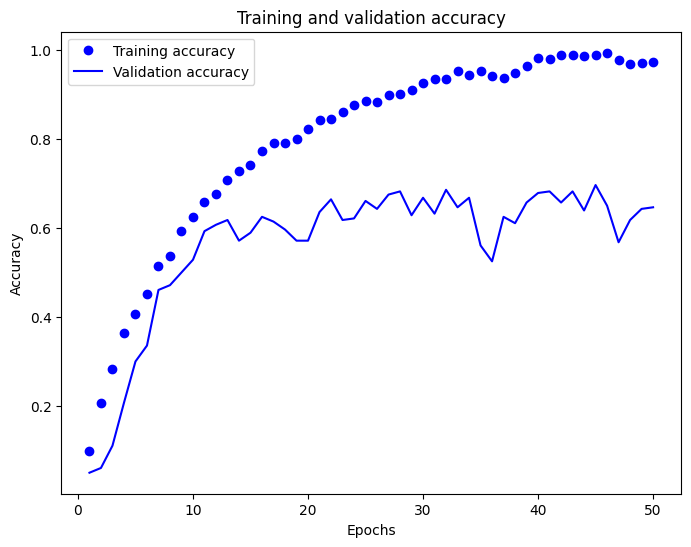

In [60]:
# Plot the accuracy curves for training and validation.

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [61]:
# Save and export the model

model.save('model_esc50_basic.h5')

### Confussion matrix

19/19 [==============================] - 1s 16ms/step


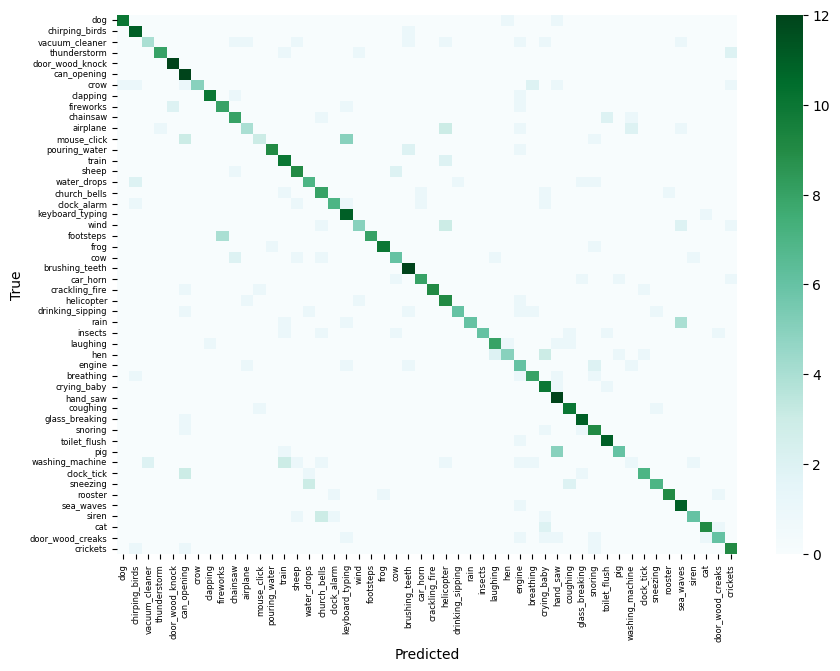

In [62]:
y_true = y_test
y_pred = model.predict(np.array(X_test_wav))
y_pred = np.argmax(y_pred, axis=1)

# Get the class names in the order corresponding to the class indices
class_names = [reversed_labels[i] for i in range(len(reversed_labels))]

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plotting using seaborn
plt.figure(figsize=(10,7))
sns.heatmap(cm, cmap="BuGn", xticklabels=class_names, yticklabels=class_names)
plt.tick_params(axis='both', which='major', labelsize=6)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Visualization of the output of the LLF layer

In [63]:
idx = 55
sample = X_test_wav[idx]
sample = sample.reshape(1, AUDIO_LENGTH * SR) # Add a batch dimension

1/1 [==============================] - 0s 313ms/step


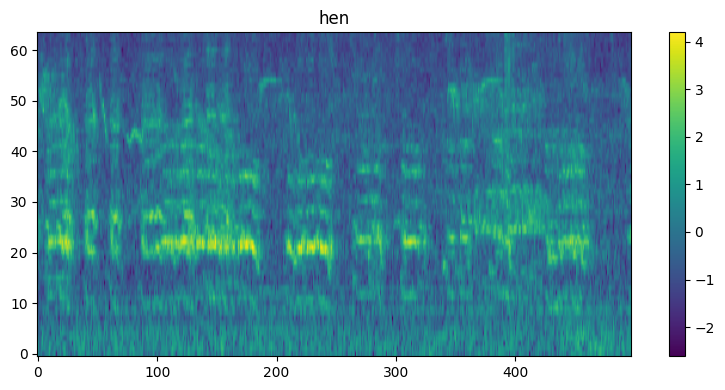

In [64]:
# Get the output of the SpectrogramLayer
spectrogram_model = Model(inputs=model.inputs, outputs=model.get_layer(index=0).output)
spectrogram_output = spectrogram_model.predict(sample)

# Create a figure with custom size (e.g., width=10 inches, height=6 inches)
fig, ax = plt.subplots(figsize=(8, 4))
ax.set_title(reversed_labels[y_test[idx]])
spectrogram = spectrogram_output.squeeze().T  # Transpose the spectrogram and remove redundant dimensions

img = ax.imshow(spectrogram, aspect='auto', origin='lower', cmap='viridis')
fig.colorbar(img, ax=ax)

plt.tight_layout()
plt.show()

## Depthwise Spearable Convolutions

In [85]:
class LLF(Layer):
    def __init__(self, sample_rate, frame_length, frame_step, num_mel_bins=64, lower_freq=125, upper_freq=7500, log_offset=0.001, **kwargs):
        super(LLF, self).__init__(**kwargs)
        self.sample_rate = sample_rate
        self.frame_length = frame_length
        self.frame_step = frame_step
        self.num_mel_bins = num_mel_bins
        self.lower_freq = lower_freq
        self.upper_freq = upper_freq
        self.log_offset = log_offset

    def call(self, inputs):
        
        # Convert numpy array to Tensor and normalize based on its actual max and min values
        wav = tf.cast(inputs, tf.float32)
        audio_tensor = (wav - tf.math.reduce_min(wav)) / (tf.math.reduce_max(wav) - tf.math.reduce_min(wav)) * 2 - 1
        
        # Compute the Short-Time Fourier Transform (STFT)
        stft = tf.signal.stft(wav, self.frame_length, self.frame_step, window_fn=tf.signal.hann_window)

        # Compute the spectrogram
        spectrogram = tf.abs(stft)

        # Compute the mel-spectrogram
        num_spectrogram_bins = stft.shape[-1]
        linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
            self.num_mel_bins, num_spectrogram_bins, self.sample_rate, self.lower_freq, self.upper_freq)
        mel_spectrogram = tf.tensordot(spectrogram, linear_to_mel_weight_matrix, 1)
        mel_spectrogram.set_shape(spectrogram.shape[:-1].concatenate(linear_to_mel_weight_matrix.shape[-1:]))

        # Compute the log mel-spectrogram
        log_mel_spectrogram = tf.math.log(mel_spectrogram + self.log_offset)

        # Add a channel dimension
        log_mel_spectrogram = tf.expand_dims(log_mel_spectrogram, -1)

        return log_mel_spectrogram

sample_rate = SR  # Adjust as necessary
window_size_ms = 25
window_hop_ms = 10
frame_length = sample_rate * window_size_ms // 1000
frame_step = sample_rate * window_hop_ms // 1000
AUDIO_LENGTH = 5

class HLFBlock(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(HLFBlock, self).__init__(**kwargs)
        self.seq = Sequential([
            tf.keras.layers.SeparableConv2D(32, 3, strides=2, padding='same', activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.SeparableConv2D(64, 3, padding='same', activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.SeparableConv2D(128, 3, padding='same', activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        ])

    def call(self, inputs):
        return self.seq(inputs)

class EmbeddingsBlock(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(EmbeddingsBlock, self).__init__(**kwargs)
        self.seq = Sequential([
            tf.keras.layers.Conv2D(256, 1, padding='same', activation='relu'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.GlobalAveragePooling2D(),
        ])

    def call(self, inputs):
        return self.seq(inputs)
    
HLF = HLFBlock(name='HLF')
Embeddings = EmbeddingsBlock(name='Embeddings')

# Define the model
model = Sequential([
    LLF(sample_rate, frame_length, frame_step, input_shape=(AUDIO_LENGTH*SR,)),
    HLF,
    Embeddings,
    tf.keras.layers.Dense(NUM_CLASSES),
    tf.keras.layers.Activation('softmax')  # The activation should be softmax for multi-class classification
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(np.array(X_train_wav), np.array(y_train), epochs=50, batch_size=32, validation_data=(np.array(X_val_wav), np.array(y_val)))

Epoch 1/50


2023-06-11 10:15:17.317475: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_26/Embeddings/sequential_25/dropout_7/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


70/70 [==============================] - 6s 35ms/step - loss: 3.6756 - accuracy: 0.0674 - val_loss: 3.9073 - val_accuracy: 0.0214
Epoch 2/50
70/70 [==============================] - 2s 23ms/step - loss: 3.1967 - accuracy: 0.1415 - val_loss: 3.9135 - val_accuracy: 0.0214
Epoch 3/50
70/70 [==============================] - 2s 25ms/step - loss: 2.8383 - accuracy: 0.2250 - val_loss: 3.9101 - val_accuracy: 0.0429
Epoch 4/50
70/70 [==============================] - 2s 23ms/step - loss: 2.6067 - accuracy: 0.2857 - val_loss: 3.8229 - val_accuracy: 0.0393
Epoch 5/50
70/70 [==============================] - 2s 24ms/step - loss: 2.3971 - accuracy: 0.3299 - val_loss: 3.5250 - val_accuracy: 0.0964
Epoch 6/50
70/70 [==============================] - 2s 25ms/step - loss: 2.2319 - accuracy: 0.3621 - val_loss: 3.0530 - val_accuracy: 0.1893
Epoch 7/50
70/70 [==============================] - 2s 25ms/step - loss: 2.1118 - accuracy: 0.4018 - val_loss: 2.6014 - val_accuracy: 0.3107
Epoch 8/50
70/70 [======

In [86]:
# Performance Evaluation
test_loss, test_accuracy = model.evaluate(np.array(X_test_wav), np.array(y_test), verbose=2)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

19/19 - 0s - loss: 1.5184 - accuracy: 0.6550 - 251ms/epoch - 13ms/step
Test loss: 1.5183545351028442
Test accuracy: 0.6549999713897705


In [87]:
# Computational complexity evaluation
total_params = model.count_params()
print(f'Total parameters: {total_params}')

Total parameters: 58139


In [88]:
model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 llf_7 (LLF)                 (None, 498, 64, 1)        0         
                                                                 
 HLF (HLFBlock)              (None, 31, 4, 128)        12265     
                                                                 
 Embeddings (EmbeddingsBlock  (None, 256)              33024     
 )                                                               
                                                                 
 dense_9 (Dense)             (None, 50)                12850     
                                                                 
 activation_9 (Activation)   (None, 50)                0         
                                                                 
Total params: 58,139
Trainable params: 57,691
Non-trainable params: 448
_______________________________________________

### Visualization of the training process

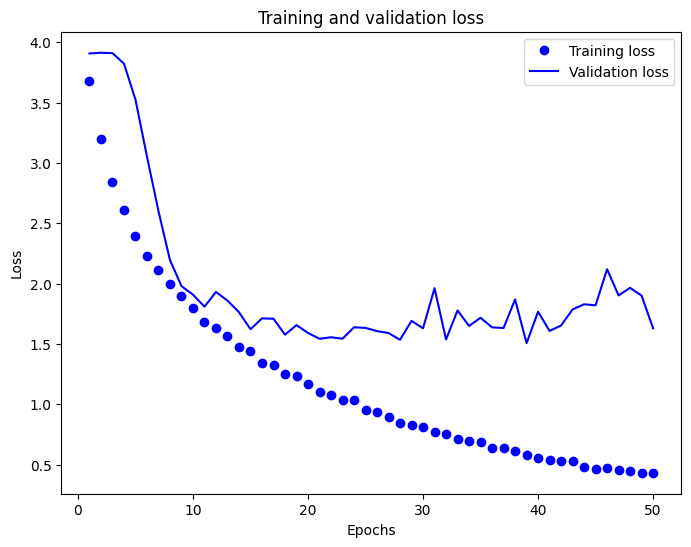

In [89]:
# Plot the loss curves for training and validation.

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

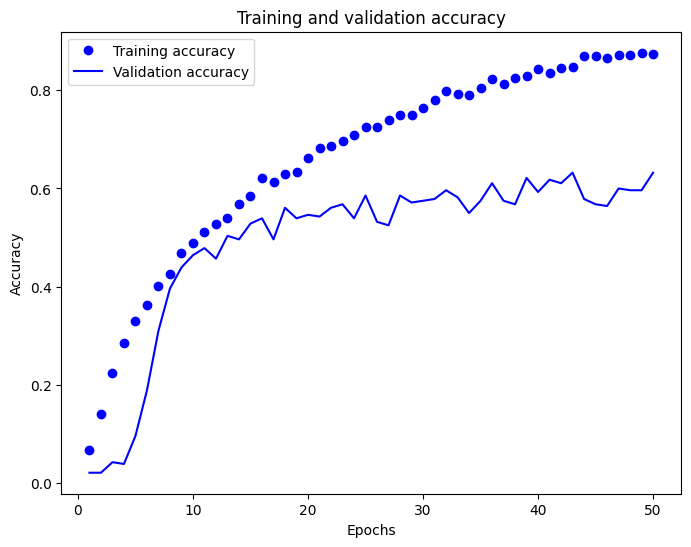

In [90]:
# Plot the accuracy curves for training and validation.

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [91]:
# Save and export the model

model.save('model_esc50_dw.h5')

### Confussion matrix

19/19 [==============================] - 1s 11ms/step


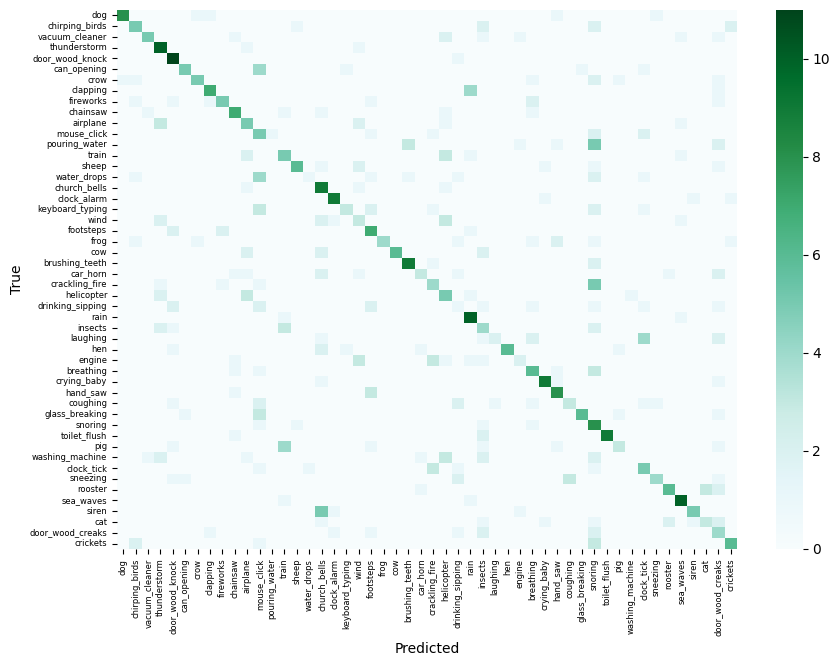

In [72]:
y_true = y_test
y_pred = model.predict(np.array(X_test_wav))
y_pred = np.argmax(y_pred, axis=1)

# Get the class names in the order corresponding to the class indices
class_names = [reversed_labels[i] for i in range(len(reversed_labels))]

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plotting using seaborn
plt.figure(figsize=(10,7))
sns.heatmap(cm, cmap="BuGn", xticklabels=class_names, yticklabels=class_names)
plt.tick_params(axis='both', which='major', labelsize=6)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Visualization of the output of the LLF layer

In [73]:
idx = 55
sample = X_test_wav[idx]
sample = sample.reshape(1, AUDIO_LENGTH * SR) # Add a batch dimension

1/1 [==============================] - 0s 434ms/step


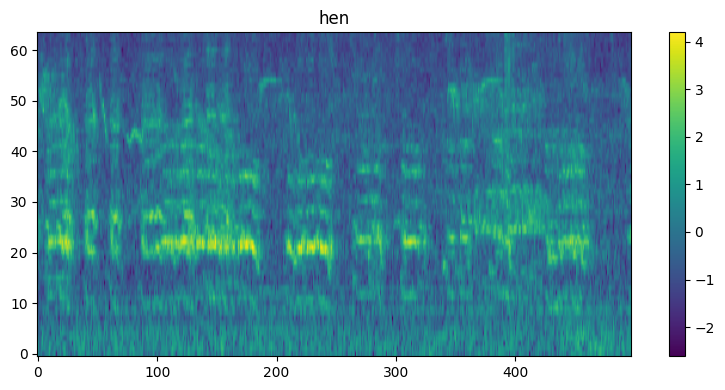

In [74]:
# Get the output of the SpectrogramLayer
spectrogram_model = Model(inputs=model.inputs, outputs=model.get_layer(index=0).output)
spectrogram_output = spectrogram_model.predict(sample)

# Create a figure with custom size (e.g., width=10 inches, height=6 inches)
fig, ax = plt.subplots(figsize=(8, 4))
ax.set_title(reversed_labels[y_test[idx]])
spectrogram = spectrogram_output.squeeze().T  # Transpose the spectrogram and remove redundant dimensions

img = ax.imshow(spectrogram, aspect='auto', origin='lower', cmap='viridis')
fig.colorbar(img, ax=ax)

plt.tight_layout()
plt.show()

## Transfer Learning with Mobilenet_v1


## Mobilenet_v1 with randomly initialized weights

In [94]:
# Load the MobileNetV1 model but exclude the top layers
mobilenet_model = MobileNet(weights=None, include_top=False, input_shape=(498, 64, 3))

class SpectrogramLayer(Layer):
    def __init__(self, sample_rate, frame_length, frame_step, num_mel_bins=64, lower_freq=125, upper_freq=7500, log_offset=0.001, **kwargs):
        super(SpectrogramLayer, self).__init__(**kwargs)
        self.sample_rate = sample_rate
        self.frame_length = frame_length
        self.frame_step = frame_step
        self.num_mel_bins = num_mel_bins
        self.lower_freq = lower_freq
        self.upper_freq = upper_freq
        self.log_offset = log_offset

    def call(self, inputs):
        
        # Convert numpy array to Tensor and normalize based on its actual max and min values
        wav = tf.cast(inputs, tf.float32)
        audio_tensor = (wav - tf.math.reduce_min(wav)) / (tf.math.reduce_max(wav) - tf.math.reduce_min(wav)) * 2 - 1
        
        # Compute the Short-Time Fourier Transform (STFT)
        stft = tf.signal.stft(wav, self.frame_length, self.frame_step, window_fn=tf.signal.hann_window)

        # Compute the spectrogram
        spectrogram = tf.abs(stft)

        # Compute the mel-spectrogram
        num_spectrogram_bins = stft.shape[-1]
        linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
            self.num_mel_bins, num_spectrogram_bins, self.sample_rate, self.lower_freq, self.upper_freq)
        mel_spectrogram = tf.tensordot(spectrogram, linear_to_mel_weight_matrix, 1)
        mel_spectrogram.set_shape(spectrogram.shape[:-1].concatenate(linear_to_mel_weight_matrix.shape[-1:]))

        # Compute the log mel-spectrogram
        log_mel_spectrogram = tf.math.log(mel_spectrogram + self.log_offset)

        # Add a channel dimension
        log_mel_spectrogram = tf.expand_dims(log_mel_spectrogram, -1)
        
        # Convert 1-channel image to 3-channel image
        x = tf.repeat(log_mel_spectrogram, 3, axis=-1)
        
        return x

sample_rate = 16000  # Adjust as necessary
window_size_ms = 25
window_hop_ms = 10
frame_length = sample_rate * window_size_ms // 1000
frame_step = sample_rate * window_hop_ms // 1000
audio_length = sample_rate*5

MobileNet_embeddings = Sequential([
    mobilenet_model,
    GlobalAveragePooling2D(),
])

# Define the model
model = Sequential([
    SpectrogramLayer(sample_rate=sample_rate, frame_length=frame_length, frame_step=frame_step, input_shape=(audio_length,)),
    MobileNet_embeddings,
    tf.keras.layers.Dense(NUM_CLASSES),
    tf.keras.layers.Activation('softmax')
])

for layer in mobilenet_model.layers:
    layer.trainable = True

# Define a learning rate
learning_rate = 0.001/2 # With low learning rates the model gets stuck at local minumums that cause overfitting.
                        # With high learning rates the performance is inconsistent

# Initialize the Adam optimizer with the lower learning rate
optimizer = Adam(learning_rate=learning_rate)

# Compile the model
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define early stopping
earlystopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='auto')

# Define model checkpoint
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='auto', verbose=1, save_best_only=True)

callbacks = [earlystopping, model_checkpoint]

# Train the model
history = model.fit(np.array(X_train_wav), np.array(y_train), epochs=50, batch_size=32, 
                    validation_data=(np.array(X_val_wav), np.array(y_val)),
                    callbacks=callbacks)

Epoch 1/50
70/70 [==============================] - ETA: 0s - loss: 3.8049 - accuracy: 0.0509
Epoch 1: val_loss improved from inf to 3.96279, saving model to best_model.h5
70/70 [==============================] - 23s 122ms/step - loss: 3.8049 - accuracy: 0.0509 - val_loss: 3.9628 - val_accuracy: 0.0179
Epoch 2/50
70/70 [==============================] - ETA: 0s - loss: 3.2578 - accuracy: 0.1259
Epoch 2: val_loss did not improve from 3.96279
70/70 [==============================] - 6s 84ms/step - loss: 3.2578 - accuracy: 0.1259 - val_loss: 4.1882 - val_accuracy: 0.0179
Epoch 3/50
70/70 [==============================] - ETA: 0s - loss: 2.8113 - accuracy: 0.2179
Epoch 3: val_loss did not improve from 3.96279
70/70 [==============================] - 6s 83ms/step - loss: 2.8113 - accuracy: 0.2179 - val_loss: 4.4489 - val_accuracy: 0.0179
Epoch 4/50
70/70 [==============================] - ETA: 0s - loss: 2.4586 - accuracy: 0.2902
Epoch 4: val_loss did not improve from 3.96279
70/70 [======

In [95]:
model = load_model('/kaggle/working/best_model.h5', custom_objects={'SpectrogramLayer': SpectrogramLayer})
model.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 spectrogram_layer_2 (Spectr  (None, 498, 64, 3)       0         
 ogramLayer)                                                     
                                                                 
 sequential_27 (Sequential)  (None, 1024)              3228864   
                                                                 
 dense_10 (Dense)            (None, 50)                51250     
                                                                 
 activation_10 (Activation)  (None, 50)                0         
                                                                 
Total params: 3,280,114
Trainable params: 3,258,226
Non-trainable params: 21,888
_________________________________________________________________


In [96]:
# Performance Evaluation
test_loss, test_accuracy = model.evaluate(np.array(X_test_wav), np.array(y_test), verbose=2)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

19/19 - 1s - loss: 2.2569 - accuracy: 0.5117 - 1s/epoch - 73ms/step
Test loss: 2.256863594055176
Test accuracy: 0.5116666555404663


In [97]:
# Computational complexity evaluation
total_params = model.count_params()
print(f'Total parameters: {total_params}')

Total parameters: 3280114


### Visualization of the training process

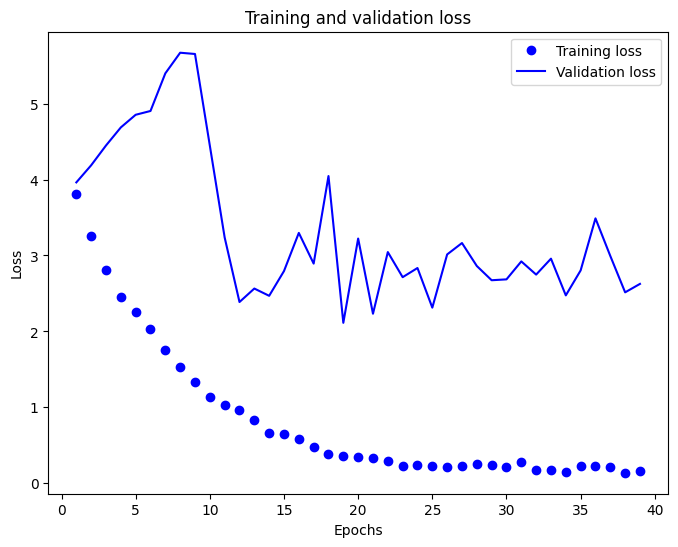

In [98]:
# Plot the loss curves for training and validation.

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

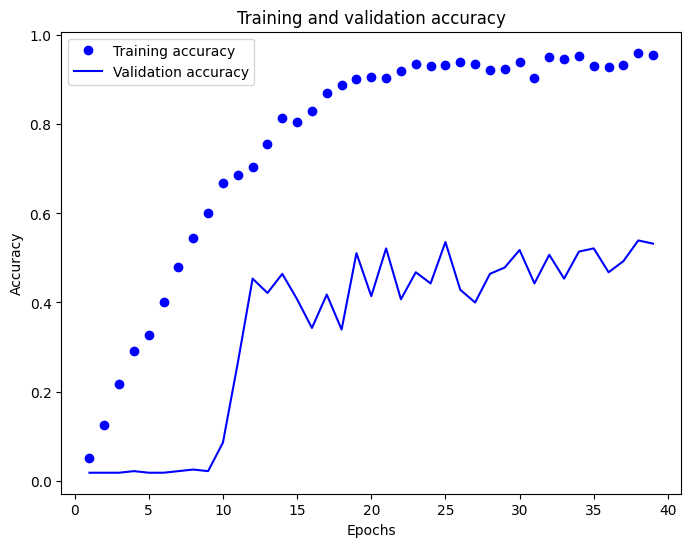

In [99]:
# Plot the accuracy curves for training and validation.

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [100]:
# Save and export the model

model.save('model_esc50_mobilenet_random.h5')

In [83]:
type(X_test_wav)

list

### Confussion matrix

19/19 [==============================] - 1s 27ms/step


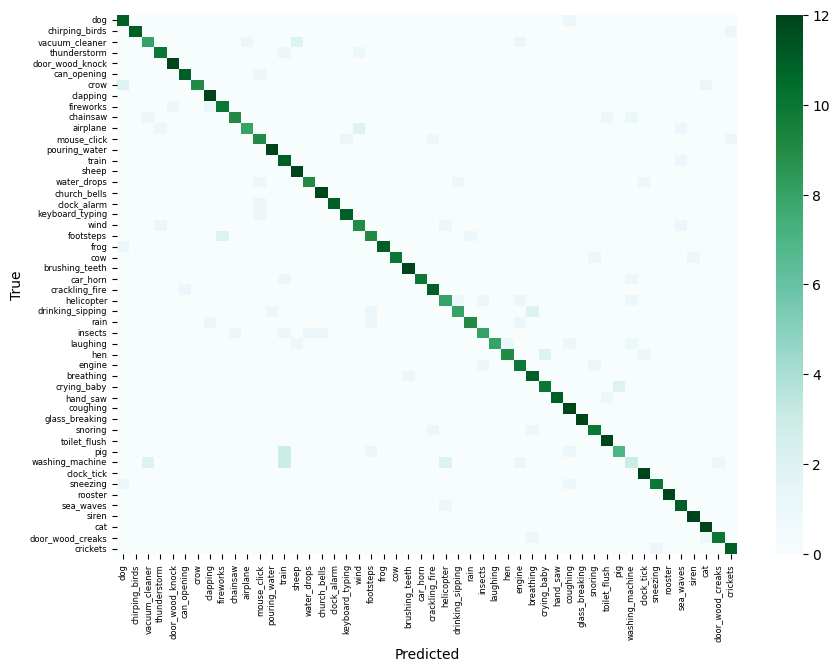

In [84]:
y_true = y_test
y_pred = model.predict(np.array(X_test_wav))
y_pred = np.argmax(y_pred, axis=1)

# Get the class names in the order corresponding to the class indices
class_names = [reversed_labels[i] for i in range(len(reversed_labels))]

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plotting using seaborn
plt.figure(figsize=(10,7))
sns.heatmap(cm, cmap="BuGn", xticklabels=class_names, yticklabels=class_names)
plt.tick_params(axis='both', which='major', labelsize=6)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Transfer learning with Imagenet

In [75]:
# Load the MobileNetV1 model but exclude the top layers
mobilenet_model = MobileNet(weights='imagenet', include_top=False, input_shape=(498, 64, 3))

class SpectrogramLayer(Layer):
    def __init__(self, sample_rate, frame_length, frame_step, num_mel_bins=64, lower_freq=125, upper_freq=7500, log_offset=0.001, **kwargs):
        super(SpectrogramLayer, self).__init__(**kwargs)
        self.sample_rate = sample_rate
        self.frame_length = frame_length
        self.frame_step = frame_step
        self.num_mel_bins = num_mel_bins
        self.lower_freq = lower_freq
        self.upper_freq = upper_freq
        self.log_offset = log_offset

    def call(self, inputs):
        
        # Convert numpy array to Tensor and normalize based on its actual max and min values
        wav = tf.cast(inputs, tf.float32)
        audio_tensor = (wav - tf.math.reduce_min(wav)) / (tf.math.reduce_max(wav) - tf.math.reduce_min(wav)) * 2 - 1
        
        # Compute the Short-Time Fourier Transform (STFT)
        stft = tf.signal.stft(wav, self.frame_length, self.frame_step, window_fn=tf.signal.hann_window)

        # Compute the spectrogram
        spectrogram = tf.abs(stft)

        # Compute the mel-spectrogram
        num_spectrogram_bins = stft.shape[-1]
        linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
            self.num_mel_bins, num_spectrogram_bins, self.sample_rate, self.lower_freq, self.upper_freq)
        mel_spectrogram = tf.tensordot(spectrogram, linear_to_mel_weight_matrix, 1)
        mel_spectrogram.set_shape(spectrogram.shape[:-1].concatenate(linear_to_mel_weight_matrix.shape[-1:]))

        # Compute the log mel-spectrogram
        log_mel_spectrogram = tf.math.log(mel_spectrogram + self.log_offset)

        # Add a channel dimension
        log_mel_spectrogram = tf.expand_dims(log_mel_spectrogram, -1)
        
        # Convert 1-channel image to 3-channel image
        x = tf.repeat(log_mel_spectrogram, 3, axis=-1)
        
        return x

sample_rate = 16000  # Adjust as necessary
window_size_ms = 25
window_hop_ms = 10
frame_length = sample_rate * window_size_ms // 1000
frame_step = sample_rate * window_hop_ms // 1000
audio_length = sample_rate*5

MobileNet_embeddings = Sequential([
    mobilenet_model,
    GlobalAveragePooling2D(),
])

# Define the model
model = Sequential([
    SpectrogramLayer(sample_rate=sample_rate, frame_length=frame_length, frame_step=frame_step, input_shape=(audio_length,)),
    MobileNet_embeddings,
    tf.keras.layers.Dense(NUM_CLASSES),
    tf.keras.layers.Activation('softmax')
])

for layer in mobilenet_model.layers[:20]: #The first 20 layers of the model are frozen
    layer.trainable = False

# Define a learning rate
learning_rate = 0.001/2 # With low learning rates the model gets stuck at local minumums that cause overfitting.
                        # With high learning rates the performance is inconsistent

# Initialize the Adam optimizer with the lower learning rate
optimizer = Adam(learning_rate=learning_rate)

# Compile the model
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define early stopping
earlystopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='auto')

# Define model checkpoint
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='auto', verbose=1, save_best_only=True)

callbacks = [earlystopping, model_checkpoint]

# Train the model
history = model.fit(np.array(X_train_wav), np.array(y_train), epochs=50, batch_size=32, 
                    validation_data=(np.array(X_val_wav), np.array(y_val)),
                    callbacks=callbacks)

Epoch 1/50
70/70 [==============================] - ETA: 0s - loss: 2.6289 - accuracy: 0.3281
Epoch 1: val_loss improved from inf to 3.35502, saving model to best_model.h5
70/70 [==============================] - 16s 82ms/step - loss: 2.6289 - accuracy: 0.3281 - val_loss: 3.3550 - val_accuracy: 0.3500
Epoch 2/50
70/70 [==============================] - ETA: 0s - loss: 0.9253 - accuracy: 0.7473
Epoch 2: val_loss improved from 3.35502 to 2.15608, saving model to best_model.h5
70/70 [==============================] - 5s 65ms/step - loss: 0.9253 - accuracy: 0.7473 - val_loss: 2.1561 - val_accuracy: 0.4964
Epoch 3/50
70/70 [==============================] - ETA: 0s - loss: 0.4280 - accuracy: 0.8915
Epoch 3: val_loss improved from 2.15608 to 1.44800, saving model to best_model.h5
70/70 [==============================] - 5s 66ms/step - loss: 0.4280 - accuracy: 0.8915 - val_loss: 1.4480 - val_accuracy: 0.6250
Epoch 4/50
70/70 [==============================] - ETA: 0s - loss: 0.1688 - accuracy

In [76]:
model = load_model('/kaggle/working/best_model.h5', custom_objects={'SpectrogramLayer': SpectrogramLayer})
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 spectrogram_layer_1 (Spectr  (None, 498, 64, 3)       0         
 ogramLayer)                                                     
                                                                 
 sequential_22 (Sequential)  (None, 1024)              3228864   
                                                                 
 dense_8 (Dense)             (None, 50)                51250     
                                                                 
 activation_8 (Activation)   (None, 50)                0         
                                                                 
Total params: 3,280,114
Trainable params: 3,244,210
Non-trainable params: 35,904
_________________________________________________________________


In [78]:
# Performance Evaluation
test_loss, test_accuracy = model.evaluate(np.array(X_test_wav), np.array(y_test), verbose=2)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

19/19 - 1s - loss: 0.6356 - accuracy: 0.8467 - 1s/epoch - 72ms/step
Test loss: 0.6356379985809326
Test accuracy: 0.846666693687439


In [79]:
# Computational complexity evaluation
total_params = model.count_params()
print(f'Total parameters: {total_params}')

Total parameters: 3280114


### Visualization of the training process

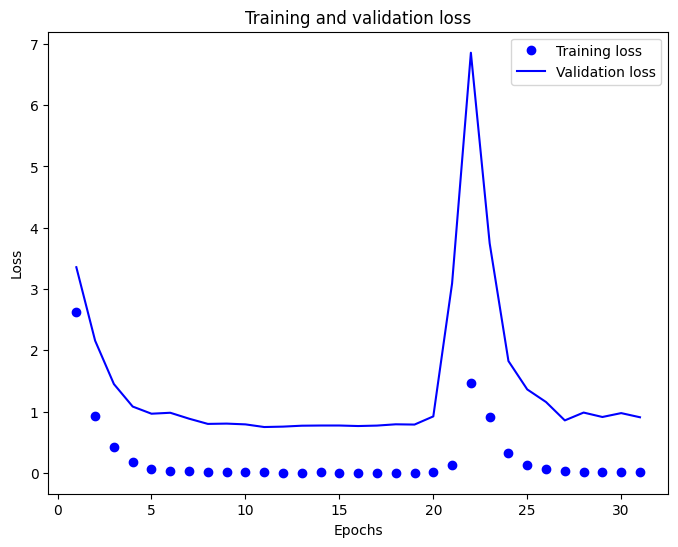

In [80]:
# Plot the loss curves for training and validation.

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

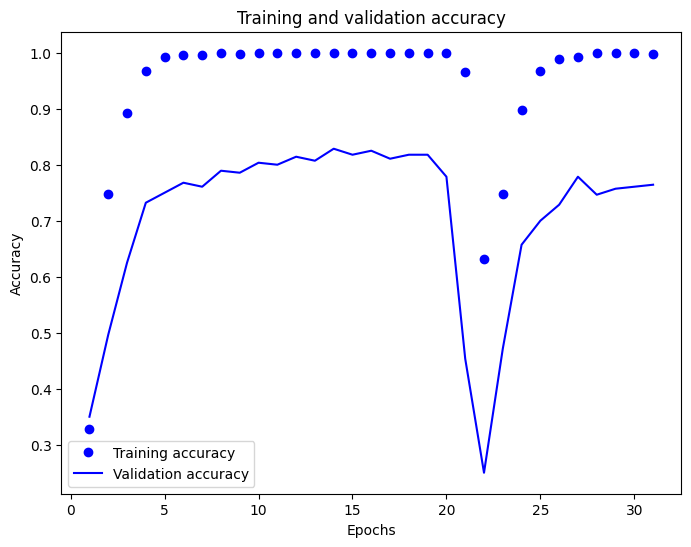

In [81]:
# Plot the accuracy curves for training and validation.

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [82]:
# Save and export the model

model.save('model_esc50_mobilenet_imagenet.h5')

In [83]:
type(X_test_wav)

list

### Confussion matrix

19/19 [==============================] - 1s 27ms/step


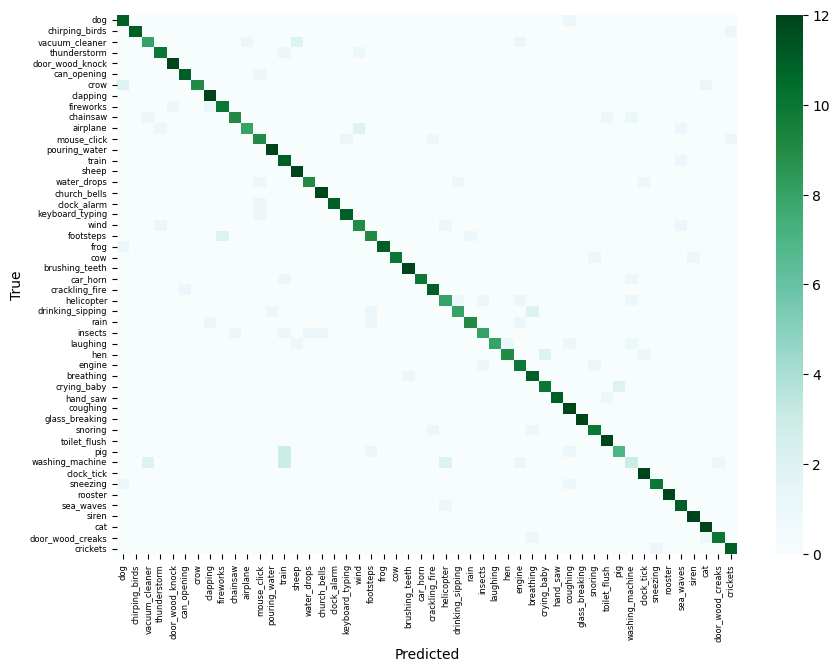

In [84]:
y_true = y_test
y_pred = model.predict(np.array(X_test_wav))
y_pred = np.argmax(y_pred, axis=1)

# Get the class names in the order corresponding to the class indices
class_names = [reversed_labels[i] for i in range(len(reversed_labels))]

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plotting using seaborn
plt.figure(figsize=(10,7))
sns.heatmap(cm, cmap="BuGn", xticklabels=class_names, yticklabels=class_names)
plt.tick_params(axis='both', which='major', labelsize=6)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()